In [12]:
library(tidyverse)
library(stringr)

# install.packages('matrixStats', repos='http://cran.us.r-project.org')
library(matrixStats)
# install.packages('ggfortify', repos='http://cran.us.r-project.org')
library(ggfortify)
# install.packages('cluster', repos='http://cran.us.r-project.org')
library(cluster)

In [13]:
# load mitotic annotations
mitosis_csv_file = '/root/gregj/results/image_processing_pipeline_tests/results_dilate_z/image_manifest_59px_tall_BinaryMitosis_goodsegs.csv'
df_mitosis = read_csv(mitosis_csv_file)

# load alldat
alldat_csv_file = "/root/gregj/results/ipp_dataset_cellnuc_seg_curated_8_24_17/data_jobs_out.csv"
df_alldat = read_csv(alldat_csv_file)

Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  .default = col_character(),
  X1 = col_integer(),
  `Unnamed: 0` = col_integer(),
  Index = col_integer(),
  Version = col_integer(),
  imageXyPixelSize = col_double(),
  imageZPixelSize = col_double(),
  memChannel = col_integer(),
  nucChannel = col_integer(),
  structureChannel = col_integer(),
  lightChannel = col_integer(),
  timePoint = col_integer(),
  outputThisCellIndex = col_integer(),
  Score1 = col_integer(),
  Score2 = col_double(),
  FinalScore = col_integer(),
  MitosisLabel = col_integer(),
  BinaryMitosisLabel = col_integer()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_character(),
  Index = col_integer(),
  SegmentationXyPixelSize = col_double(),
  SegmentationZPixelSize = col_double(),
  Version = col_double(),
  imageXyPixelSize = col_double(),
  imageZPixelSize = col_double(),
  lightChannel = col_integer(

In [14]:
# remove rows with missing data
df_mitosis = df_mitosis[complete.cases(df_mitosis), ]

# remove empty cols
drop_cols = c("X1", "Unnamed: 0")
df_mitosis = select(df_mitosis,-one_of(drop_cols))
df_alldat = select(df_alldat,-one_of(drop_cols))

Warning message in one_of(drop_cols):
"Unknown variables: `X1`, `Unnamed: 0`"

In [15]:
# functions for generating common path keys on which to join

make_simple_path_mitosis <- function(filepath_in){
    filename = str_split_fixed(filepath_in, pattern='//', n=2)[[2]]
    filename = str_split_fixed(filename, pattern='_struct.tif', n=2)[1]
    filename = str_split_fixed(filename, pattern='.czi/', n=2)[2]
    return(filename)
}

make_simple_path_alldat <- function(filepath_in){
    filename = str_split_fixed(filepath_in, pattern='/',n=2)[[2]]
    filename = str_split_fixed(filename, pattern='_struct.tif', n=2)[1]
    return(filename)
}

In [16]:
# make the common paths then join the dfs

df_mitosis %>%
    rowwise() %>%
    mutate(path = make_simple_path_mitosis(save_struct_reg_path)) ->
    df_mitosis

df_alldat %>%
    rowwise() %>%
    mutate(path = make_simple_path_alldat(save_struct_reg_path)) ->
    df_alldat

df_mitosis %>%
    select(path,MitosisLabel) %>%
    inner_join(df_alldat) ->
    df_alldat_mito

Joining, by = "path"


In [10]:
df_alldat_mito %>% write_csv("alldat_mito.csv")

In [17]:
# read in the giant errors analysis csv in order to get master ind / dp ind mapping
errors_csv_file = "/root/gregj/projects/pytorch_integrated_cell/test_aaegan/aaegan3Dv5_128D_3/struct_model/var_test_testing/all_dat.csv"
df_errors = read_csv(errors_csv_file)

Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  X1 = col_integer(),
  `Unnamed: 0` = col_integer(),
  img_index = col_integer(),
  data_provider_index = col_integer(),
  embedding_data_provider_index = col_integer(),
  embedding_train_or_test = col_character(),
  label = col_character(),
  path = col_character(),
  train_or_test = col_character(),
  tot_inten = col_double(),
  tot_inten_recon = col_double(),
  mse_orig = col_double(),
  mse_recon = col_double(),
  bce_orig = col_double(),
  bce_recon = col_double(),
  pearson_orig = col_double(),
  pearson_recon = col_double(),
  corr_orig = col_double(),
  corr_recon = col_double()
)


In [18]:
# find the distinct cells
df_errors %>%
    distinct(img_index, path, data_provider_index, train_or_test, label) ->
    df_err_dist_keys

In [19]:
# join the mitotic annotation into the img / dp indexed set

df_alldat_mito %>% 
    select(path, MitosisLabel) %>%
    inner_join(df_err_dist_keys) ->
    df_mito_indexed

Joining, by = "path"


In [20]:
df_z = read_csv("latent_space_embeddings.csv")
drop_cols = c("X1")
df_z = select(df_z,-one_of(drop_cols))

Warning message:
"Missing column names filled in: 'X1' [1]"Parsed with column specification:
cols(
  .default = col_double(),
  X1 = col_integer(),
  phase = col_character(),
  dp_index = col_integer()
)
See spec(...) for full column specifications.


In [21]:
names(df_mito_indexed)[names(df_mito_indexed) == 'data_provider_index'] <- 'dp_index'
names(df_mito_indexed)[names(df_mito_indexed) == 'train_or_test'] <- 'phase'

df_mito_indexed %>% glimpse

Observations: 3,958
Variables: 6
$ path         <chr> "20170203_C01_004.czi_3", "20170203_C01_004.czi_4", "2...
$ MitosisLabel <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
$ img_index    <int> 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, ...
$ dp_index     <int> 1586, 170, 1587, 1588, 1589, 1590, 1591, 1592, 1593, 1...
$ phase        <chr> "train", "test", "train", "train", "train", "train", "...
$ label        <chr> "Tom20", "Tom20", "Tom20", "Tom20", "Tom20", "Tom20", ...


In [22]:
df_z %>%
    inner_join(df_mito_indexed) %>%
    select(path, img_index, phase, dp_index, label, MitosisLabel, everything()) ->
    df_z_mito

df_z_mito$MitosisLabel = as.factor(df_z_mito$MitosisLabel)

Joining, by = c("phase", "dp_index")


Saving 6.67 x 6.67 in image


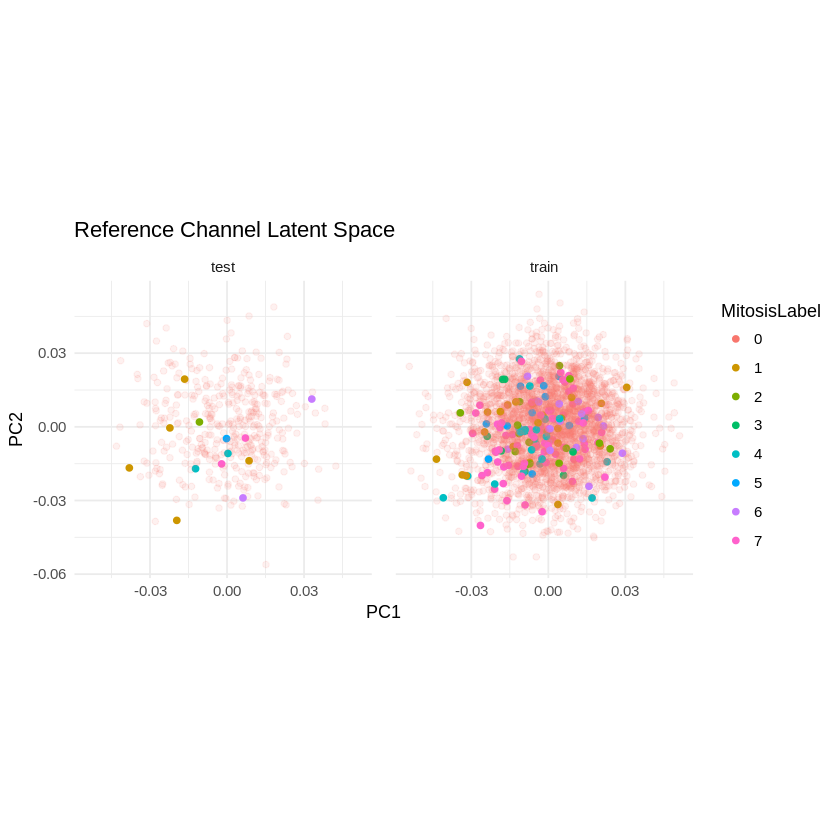

In [26]:
df_ref = df_z_mito[1:134]
df_ref$alpha = 1.0
df_ref[df_ref$MitosisLabel == 0,]$alpha = 0.1 
df_ref_dat = df_ref[7:134]

autoplot(prcomp(df_ref_dat),
         data=df_ref,
         colour='MitosisLabel',
         alpha='alpha') +
scale_alpha(guide = 'none') +
facet_wrap(~phase) +
theme_minimal() +
theme(aspect.ratio=1, panel.spacing.x=unit(1, "lines")) +
labs(title="Reference Channel Latent Space") ->
    p

ggsave(p, filename = "z_ref_by_mito.png", device="png", dpi = 600)
p

Saving 6.67 x 6.67 in image


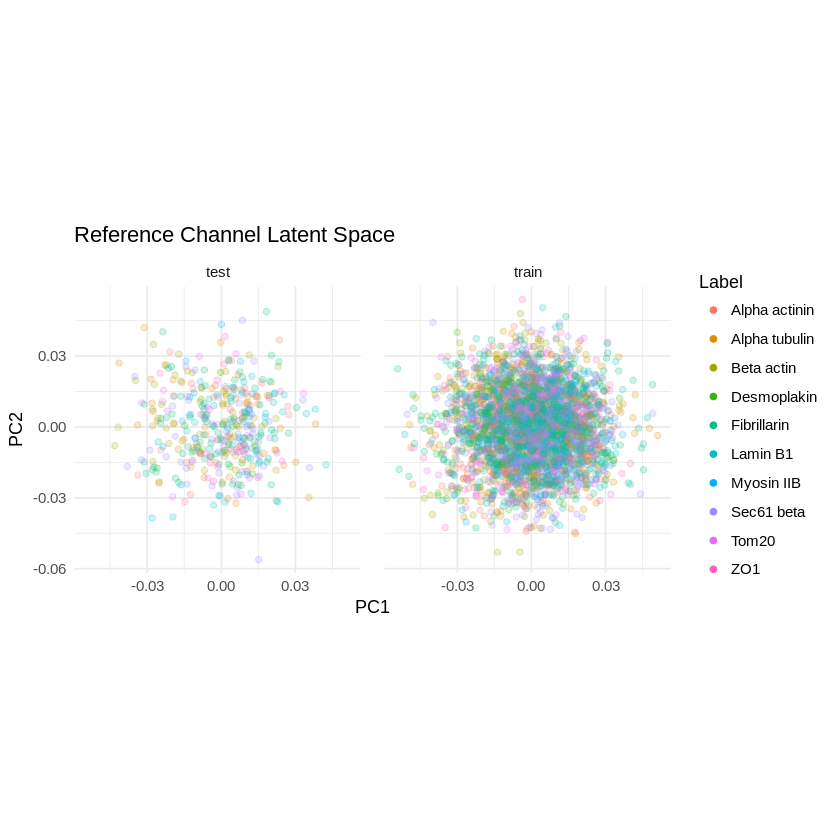

In [24]:
df_ref = df_z_mito[1:134]
df_ref$alpha = 1.0
df_ref[df_ref$MitosisLabel == 0,]$alpha = 0.1 
df_ref_dat = df_ref[7:134]

autoplot(prcomp(df_ref_dat),
         data=df_ref,
         colour='label',
         alpha=0.2) +
scale_alpha(guide = 'none') +
facet_wrap(~phase) +
theme_minimal() +
theme(aspect.ratio=1, panel.spacing.x=unit(1, "lines")) +
guides(colour = guide_legend(override.aes = list(alpha = 1))) +
labs(title="Reference Channel Latent Space", color="Label") ->
    p

ggsave(p, filename = "z_ref_by_label.png", device="png", dpi = 600)
p

Saving 6.67 x 6.67 in image


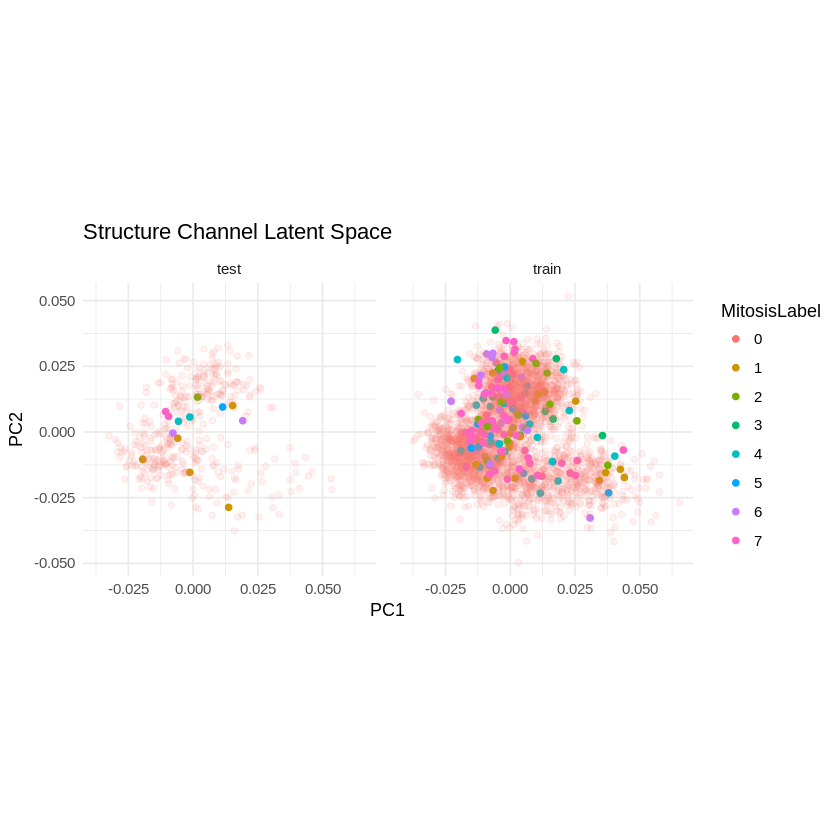

In [27]:
df_struct = df_z_mito[,c(1:6, 135:262)]
df_struct$alpha = 1.0
df_struct[df_struct$MitosisLabel == 0,]$alpha = 0.1 
df_struct_dat = df_struct[7:134]

autoplot(prcomp(df_struct_dat),
         data=df_struct,
         colour='MitosisLabel',
         alpha='alpha') +
scale_alpha(guide = 'none') +
facet_wrap(~phase) +
theme_minimal() +
theme(aspect.ratio=1, panel.spacing.x=unit(1, "lines")) +
labs(title="Structure Channel Latent Space") ->
    p

ggsave(p, filename = "z_struct_by_mito.png", device="png", dpi = 600)
p

Saving 6.67 x 6.67 in image


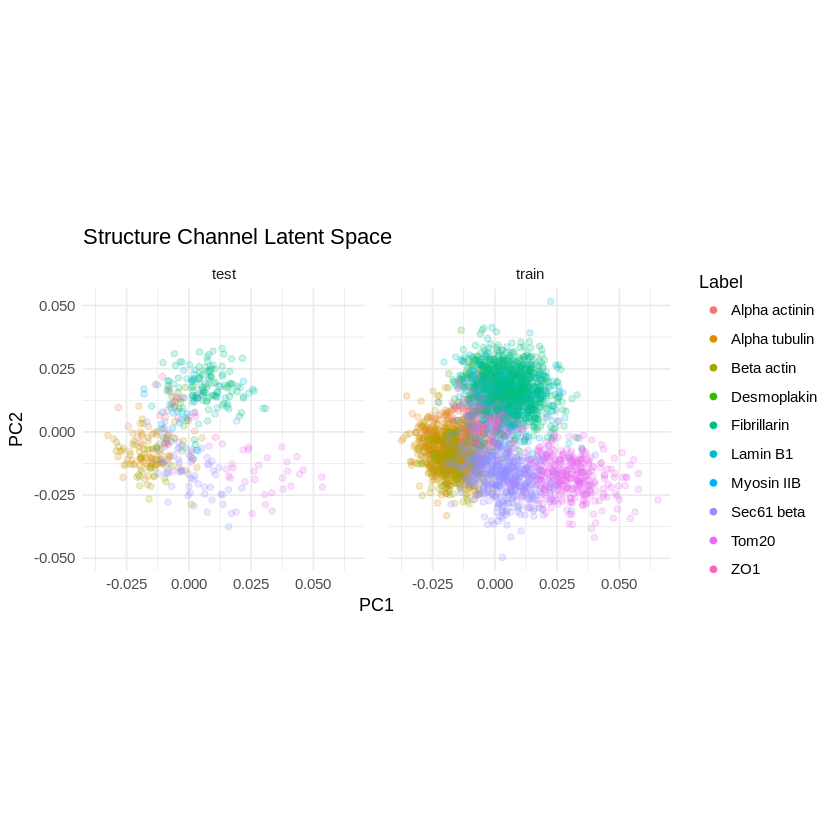

In [25]:
df_struct = df_z_mito[,c(1:6, 135:262)]
df_struct$alpha = 1.0
df_struct[df_struct$MitosisLabel == 0,]$alpha = 0.1 
df_struct_dat = df_struct[7:134]

autoplot(prcomp(df_struct_dat),
         data=df_struct,
         colour='label',
         alpha = 0.2,
         x = 1,
         y = 2) +
scale_alpha(guide = 'none') +
facet_wrap(~phase) +
theme_minimal() +
theme(aspect.ratio=1, panel.spacing.x=unit(1, "lines")) +
guides(colour = guide_legend(override.aes = list(alpha = 1))) +
labs(title="Structure Channel Latent Space", color="Label") ->
    p

ggsave(p, filename = "z_struct_by_label.png", device="png", dpi = 600)
p

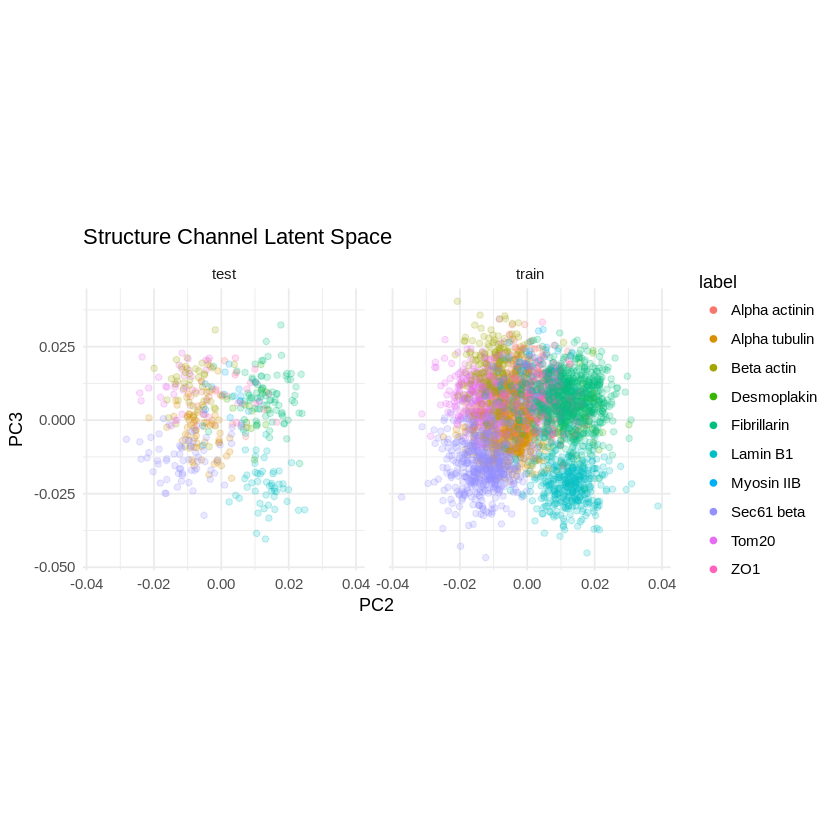

In [278]:
df_struct = df_z_mito[,c(1:6, 135:262)]
df_struct$alpha = 1.0
df_struct[df_struct$MitosisLabel == 0,]$alpha = 0.1 
df_struct_dat = df_struct[7:134]

autoplot(prcomp(df_struct_dat),
         data=df_struct,
         colour='label',
         alpha = 0.2,
         x = 2,
         y = 3) +
scale_alpha(guide = 'none') +
facet_wrap(~phase) +
theme_minimal() +
theme(aspect.ratio=1, panel.spacing.x=unit(1, "lines")) +
labs(title="Structure Channel Latent Space") +
guides(colour = guide_legend(override.aes = list(alpha = 1)))

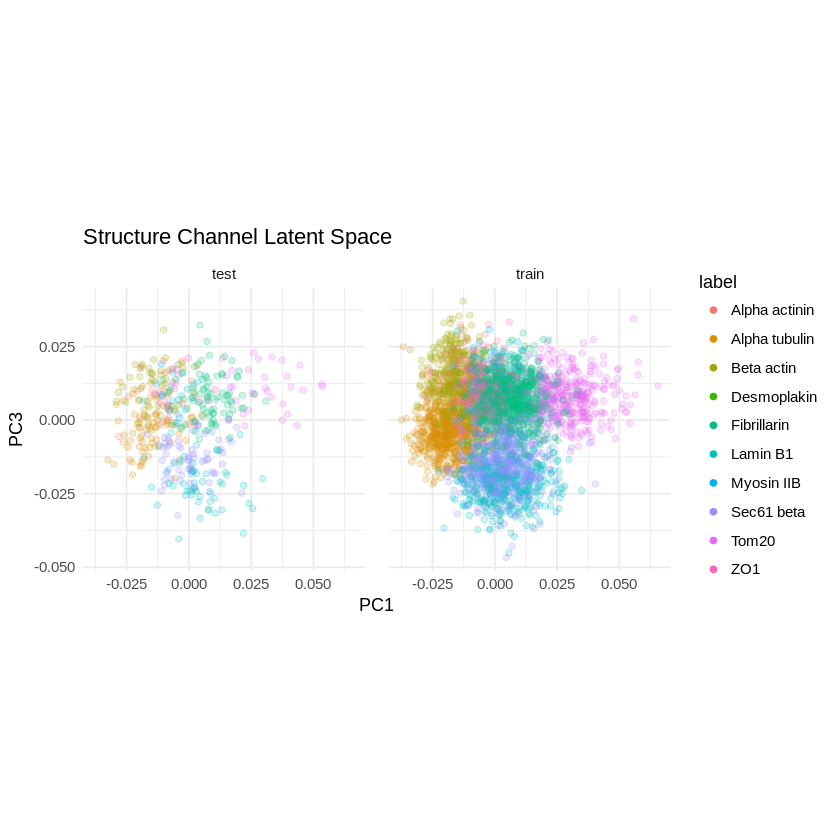

In [279]:
df_struct = df_z_mito[,c(1:6, 135:262)]
df_struct$alpha = 1.0
df_struct[df_struct$MitosisLabel == 0,]$alpha = 0.1 
df_struct_dat = df_struct[7:134]

autoplot(prcomp(df_struct_dat),
         data=df_struct,
         colour='label',
         alpha = 0.2,
         x = 1,
         y = 3) +
scale_alpha(guide = 'none') +
facet_wrap(~phase) +
theme_minimal() +
theme(aspect.ratio=1, panel.spacing.x=unit(1, "lines")) +
labs(title="Structure Channel Latent Space") +
guides(colour = guide_legend(override.aes = list(alpha = 1)))

In [316]:
# save out first five pcs for pcaso

struct_pca = prcomp(df_struct_dat, center = TRUE, scale = TRUE) 
feature_vector = struct_pca$rotation[,1:5]
compact_data = as.matrix(df_struct_dat) %*% feature_vector
compact_data %>% as_tibble %>% cbind(df_struct[,c(2,3,5,6)]) %>% write_csv("pcaso.csv")

In [ ]:
# find mediods for each mito class 

In [419]:
find_mediod <- function(df_in,
                        feature,
                        meta_data_cols=c('path', 'img_index', 'phase', 'dp_index', 'label', 'MitosisLabel'),
                        drop_cols=c("alpha")) {
    
    med_df = slice(df_in, 0)
    labs = df_in %>% select_(feature) %>% table %>% names
    
    for (lab in labs) {
        
        s = paste(feature, "==", sQuote(lab))
        df_in %>% filter_(s) ->
            df_tmp

        df_tmp %>%
            select(-one_of(meta_data_cols)) %>%
            pam(k=1) ->
            med

        med_df = rbind(med_df, df_tmp[med$id.med,])
    }
    med_df %>%
        select(-one_of(drop_cols)) ->
        med_df
    return(med_df)
}

In [423]:
find_mediod(df_ref,"MitosisLabel") %>% write_csv("z_ref_mito_mediods.csv")

In [424]:
find_mediod(df_struct,"MitosisLabel") %>% write_csv("z_struct_mito_mediods.csv")

In [425]:
find_mediod(df_struct,"label") %>% write_csv("z_struct_label_mediods.csv")